In [2]:
#data packages:
import pandas as pd
import numpy as np
from scipy import stats
import random
#plot packages:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
#neural network packages:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical

Using TensorFlow backend.
/home/john/anaconda3/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.23) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


## 1. The Dataset
This sample dataset gives event reports from an on-demand hiring service. From the assignment text: **'we want to use market data to build a model that suggests hourly rates to Taskers that would maximize their opportunity to be hired.'** My goal is to produce a machine learning model which determines likelihood of hire for a tasker, given the sample dataset.

### 1.1 Exploring the dataset
The dataset looks like this:

In [3]:
DF=pd.read_csv('sample.csv')
DF[:20]

,recommendation_id,created_at,tasker_id,position,hourly_rate,num_completed_tasks,hired,category
0,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,2017-09-01 00:32:25,1009185352,1,38,151,0,Furniture Assembly
1,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,2017-09-01 00:32:25,1006892359,2,40,193,0,Furniture Assembly
2,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,2017-09-01 00:32:25,1012023956,3,28,0,0,Furniture Assembly
3,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,2017-09-01 00:32:25,1009733517,4,43,303,0,Furniture Assembly
4,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,2017-09-01 00:32:25,1013579273,5,29,39,0,Furniture Assembly
5,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,2017-09-01 00:32:25,1012043028,6,28,2,0,Furniture Assembly
6,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,2017-09-01 00:32:25,1013470741,7,29,9,0,Furniture Assembly
7,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,2017-09-01 00:32:25,1009557645,8,29,8,0,Furniture Assembly
8,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,2017-09-01 00:32:25,1010800768,9,28,0,0,Furniture Assembly
9,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,2017-09-01 00:32:25,1009072269,10,35,59,0,Furniture Assembly


The dataset includes sets of bids, in groups of 15. These bids are indexed by unique task IDs in the 'recommendation_id' category. For each tasker, the independent variables are hourly rate (actively set by the tasker), number of completed tasks (not immediately influenced by the tasker), and job category. The dependent variable is a binary, 'hired'.

Each unique recommendation_id is associated with 15 'bids', from which the customer selects one tasker. As you can see, in rows 15-19 the recommendation_id has changed, and the 'position' variable resets at 1.
The assignment stipulates that the tasker has no control over their position in the ranking, therefore I chose not to model that part of the problem. Likewise the tasker has no immediate control over their personal number of completed tasks; they can only change their bid. 

Therefore, assuming that the customers are comparing the 15 taskers in their recommendation, I thought we might be able to compare numbers within each bid, to further predict the hiring likelihood for each tasker in the context of each job. 

### 1.2 Expressing hourly_rate and num_completed_tasks proportionally to the mean and max within that recommendation set
I added four new columns to the dataset, which express the user's bid relative the 15-person recommendation set they occurred in: user's hourly_rate as a fraction of the mean and max hourly_rates in that recommendation, and user's num_completed_tasks as a fraction of the mean and max completed tasks in their recommendation. To do this I separated the dataset by recommendation (remember, each 'recommendation' is a group of 15) and calculated each tasker's hourly_rate and num_completed_tasks as a ratio to the max and mean of those values, within that recommendation. I then added the resulting four new columns to the dataset.
At the end I confirm proportionality by checking that the average of the mean fractions is ~=1, and then print the first recommendation from the dataset. As you can see, it remains unchanged except for the four new columns.

In [4]:
#There are ~15 recommendations for each recommendation_id, so it can index groupings
len(DF)/len(set(DF.recommendation_id))

14.285714285714286

However, the python set() function doesn't keep the order in which the recommendations occur in the DF, so we must take them by iterating the rows:

In [5]:
#generate the recommendation_id list from the DF:
reclist=[]
for row in DF.iterrows():
	recID=row[1][0]
	if recID not in reclist:
		reclist.append(recID)

Now we generate the new columns and add them to the dataset:

In [6]:
#initialize lists
t_meanratelist=[]
t_maxratelist=[]
t_meancomplist=[]
t_maxcomplist=[]

for recommendation in reclist:
    subDF=DF[DF['recommendation_id']==recommendation]
    meanrate=subDF.hourly_rate.mean()
    maxrate=subDF.hourly_rate.max()
    meancomp=subDF.num_completed_tasks.mean()
    maxcomp=subDF.num_completed_tasks.max()	
    for tasker in subDF.iterrows():
        t_rate=tasker[1][4]
        t_meanrate=(t_rate)/meanrate
        t_maxrate=(t_rate)/maxrate
        t_meanratelist.append(t_meanrate)
        t_maxratelist.append(t_maxrate)
        t_comp=tasker[1][5]
        t_meancomp=(t_comp)/meancomp
        t_maxcomp=(t_comp)/maxcomp
        t_meancomplist.append(t_meancomp)
        t_maxcomplist.append(t_maxcomp)
        
#include the vectorized lists into the original DF as columns:
DF['meanrate']=t_meanratelist
DF['maxrate']=t_maxratelist
DF['meancomp']=t_meancomplist
DF['maxcomp']=t_maxcomplist

In [7]:
#confirm that the proportionality is working:
print('Average of mean-rate column: '+str(np.mean(DF.meanrate)))
print('Average of max-rate column: '+str(np.mean(DF.meancomp)))

Average of mean-rate column: 0.999999999999993
Average of max-rate column: 0.9999999999999957


In [8]:
DF[:5]

,recommendation_id,created_at,tasker_id,position,hourly_rate,num_completed_tasks,hired,category,meanrate,maxrate,meancomp,maxcomp
0,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,2017-09-01 00:32:25,1009185352,1,38,151,0,Furniture Assembly,1.144578,0.76,1.281109,0.165208
1,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,2017-09-01 00:32:25,1006892359,2,40,193,0,Furniture Assembly,1.204819,0.80,1.637443,0.211160
2,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,2017-09-01 00:32:25,1012023956,3,28,0,0,Furniture Assembly,0.843373,0.56,0.000000,0.000000
3,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,2017-09-01 00:32:25,1009733517,4,43,303,0,Furniture Assembly,1.295181,0.86,2.570701,0.331510
4,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,2017-09-01 00:32:25,1013579273,5,29,39,0,Furniture Assembly,0.873494,0.58,0.330882,0.042670


### 1.3 Point-biserial tests of significance for each independent variable
Are the new metrics really more meaningful predictors than the old ones alone? Let's compare their correlations. The scipy.stats.pointbiserialr() function returns a correlation value, r, as well as a p-value for a two-tailed p-value test. Higher correlation is better, lower p-value is better. As you can see, the p-values for the proportional values are very small; these values do indeed predict the difference between the 'hired' and 'not hired' groups.

In [9]:
print(stats.pointbiserialr(DF.meanrate,DF.hired))
print(stats.pointbiserialr(DF.maxrate,DF.hired))
print(stats.pointbiserialr(DF.meancomp,DF.hired))
print(stats.pointbiserialr(DF.maxcomp,DF.hired))

PointbiserialrResult(correlation=-0.070082274983476064, pvalue=5.5268594141237121e-34)
PointbiserialrResult(correlation=-0.054077442207914481, pvalue=7.0529139912511035e-21)
PointbiserialrResult(correlation=0.053839248689665192, pvalue=1.0427384475296692e-20)
PointbiserialrResult(correlation=0.060609138630314863, pvalue=8.017631159830535e-26)


But do they predict the difference more than the raw values alone? Let's run the point-biserial p-test for the 'hired' category against the hourly_rate and num_completed_tasks columns:

In [10]:
print(stats.pointbiserialr(DF.hourly_rate,DF.hired))
print(stats.pointbiserialr(DF.num_completed_tasks,DF.hired))

PointbiserialrResult(correlation=-0.046519106252867579, pvalue=7.5441719622639566e-16)
PointbiserialrResult(correlation=0.041824885364732889, pvalue=4.2562678973772039e-13)


As you can see, the p-values for the proportional weights are far smaller than the p-values for the raw weights. **Because all of these p-values are far below .05, we reject the null hypothesis for each of these variables.** Because the p-values of the group-proportional weights are 10^10 to 10^21 smaller than those for the unprocessed weights, we can conclude that the process adds useful information to the model.

### 1.4 Splitting the datasets by category:
Having produced the additional vectors, can we find whether the separate job categories are differently correlated by these metrics? Let's find out. First we split the DF into three subDFs, one for each category, then we run the same correlations from above within each:

In [11]:
furnitureDF=DF[DF['category']=='Furniture Assembly']
moveDF=DF[DF['category']=='Moving Help']
mountDF=DF[DF['category']=='Mounting']
list(set(DF.category))

['Moving Help', 'Mounting', 'Furniture Assembly']

In [12]:
DFcorrelates=[
stats.pointbiserialr(DF.hourly_rate,DF.hired)[0],
stats.pointbiserialr(DF.meanrate,DF.hired)[0],
stats.pointbiserialr(DF.maxrate,DF.hired)[0],
stats.pointbiserialr(DF.num_completed_tasks,DF.hired)[0],
stats.pointbiserialr(DF.meancomp,DF.hired)[0],
stats.pointbiserialr(DF.maxcomp,DF.hired)[0]
]
                    
moveDFcorrelates=[
stats.pointbiserialr(moveDF.hourly_rate,moveDF.hired)[0],
stats.pointbiserialr(moveDF.meanrate,moveDF.hired)[0],
stats.pointbiserialr(moveDF.maxrate,moveDF.hired)[0],
stats.pointbiserialr(moveDF.num_completed_tasks,moveDF.hired)[0],
stats.pointbiserialr(moveDF.meancomp,moveDF.hired)[0],
stats.pointbiserialr(moveDF.maxcomp,moveDF.hired)[0]
]
                  
mountDFcorrelates=[
stats.pointbiserialr(mountDF.hourly_rate,mountDF.hired)[0],
stats.pointbiserialr(mountDF.meanrate,mountDF.hired)[0],
stats.pointbiserialr(mountDF.maxrate,mountDF.hired)[0],
stats.pointbiserialr(mountDF.num_completed_tasks,mountDF.hired)[0],
stats.pointbiserialr(mountDF.meancomp,mountDF.hired)[0],
stats.pointbiserialr(mountDF.maxcomp,mountDF.hired)[0]
]

furnitureDFcorrelates=[
stats.pointbiserialr(furnitureDF.hourly_rate,furnitureDF.hired)[0],
stats.pointbiserialr(furnitureDF.meanrate,furnitureDF.hired)[0],
stats.pointbiserialr(furnitureDF.maxrate,furnitureDF.hired)[0],
stats.pointbiserialr(furnitureDF.num_completed_tasks,furnitureDF.hired)[0],
stats.pointbiserialr(furnitureDF.meancomp,furnitureDF.hired)[0],
stats.pointbiserialr(furnitureDF.maxcomp,furnitureDF.hired)[0]
]
x=np.arange(len(DFcorrelates))

### 1.5 Plotting point-biserial correlation of each column for each variable:

In [13]:
# plot data
# use zorder to put bars in front of grid
bar_width=0.15
plt.bar(x,DFcorrelates,width=bar_width,color='green',zorder=2)
plt.bar(x+bar_width, moveDFcorrelates, width=bar_width, color='red', zorder=2)
plt.bar(x+bar_width*2, mountDFcorrelates, width=bar_width, color='orange', zorder=2)
plt.bar(x+bar_width*3, furnitureDFcorrelates, width=bar_width, color='blue', zorder=2)

# labels
plt.xticks(x+bar_width*2, ['hourly_rate','meanrate','maxrate','num_completed_tasks','meancomp','maxcomp'])
plt.title('Point-biserial correlation of variables to hired axis:')
plt.xlabel('column name')
plt.ylabel('point-biserial r')

#legend
green_patch=mpatches.Patch(color='green',label='DF')
red_patch=mpatches.Patch(color='red',label='moveDF')
orange_patch=mpatches.Patch(color='orange',label='mountDF')
blue_patch=mpatches.Patch(color='blue',label='furnitureDF')
plt.legend(handles=[green_patch,red_patch,orange_patch,blue_patch])

#grid
plt.grid(axis='y')

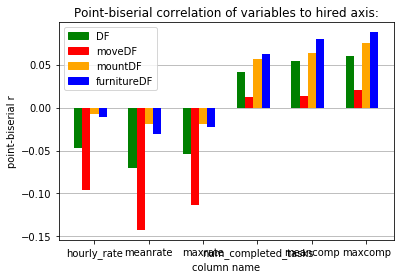

In [14]:
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()

* As you can see, the 'completed_tasks' metrics are stronger predictors of hire for 'mounting' and 'furniture assembly' categories. Conversely, the rate metrics are by far the largest predictor for moving.
*  Unsurprisingly, the correlation between hourly_rate and hired is always negative, and the correlation between num_completed_tasks and hired is always positive. 
* Finally, even though the correlation for the group-ratio measures are larger, they follow similar direction and scale to the raw values.

In [15]:
plt.close()

## 2. Training a neural network to predict 'hired' from tasker variables

This is a good problem for an artificial neural network. The correlations are clear, but they change based on category. The neural network will find the appropriate and relevant weights and measures between the independent variables (rate and task completed measures) and the dependent variable, 'hired'.

### 2.1 the Training Dataset
We'll need to convert the data we're keeping to numbers. We can neglect ID values, and the timestamp. By converting 'category' from string to number, we can train a neural network to classify bids as 'hired' or 'not hired'. Because there are only three categories, it's easy enough to hardcode them.

In [16]:
trainDF=DF.drop(['tasker_id','recommendation_id','created_at','position'], axis=1)
categorylist=[]


for row in DF.iterrows(): 
    if row[1][7]=='Moving Help':
        categorylist.append(0)
    if row[1][7]=='Mounting':
        categorylist.append(1)
    if row[1][7]=='Furniture Assembly':
        categorylist.append(2)

trainDF.category=categorylist

trainDF[:5]

,hourly_rate,num_completed_tasks,hired,category,meanrate,maxrate,meancomp,maxcomp
0,38,151,0,2,1.144578,0.76,1.281109,0.165208
1,40,193,0,2,1.204819,0.80,1.637443,0.211160
2,28,0,0,2,0.843373,0.56,0.000000,0.000000
3,43,303,0,2,1.295181,0.86,2.570701,0.331510
4,29,39,0,2,0.873494,0.58,0.330882,0.042670


### 2.2 Training the neural network, grid parameter search

To train a neural network, we sample a set of the data to be a training dataset, and hold out the remainder as a validation dataset. To minimize overfitting our model, we minimize variance, meaning we keep the network model with the highest validation accuracy. I've included a few likely network sizes in layerslist and nodeslist, and automated the building and training of a neural network given these parameters. 

In [17]:
#variables for the neural network
targetcolumn='hired'
layerslist=[2,5,10] #these need to hold the series of parameters we know tend to find solutions
nodeslist=[25,50,100]
epochs=10
activator='relu'
lossfcn='categorical_crossentropy' 

In [20]:
#function for training the network:
def TrainNet(TargetDF, layers, nodes, epochs, activator, lossfcn):
	target=to_categorical(TargetDF[targetcolumn])
	predictors=TargetDF.drop([targetcolumn], axis=1).as_matrix()
	n_cols=predictors.shape[1]
	model=Sequential()
	model.add(Dense(nodes,activation=activator,input_shape=(n_cols,)))
	for layer in range(0,layers):
		model.add(Dense(nodes,activation=activator))
	model.add(Dense(2,activation='softmax'))
	model.compile(optimizer='adam',loss=lossfcn, metrics=['categorical_accuracy'])
	model_training=model.fit(predictors,target, validation_split=0.7, epochs=epochs, shuffle=True, callbacks=[earlystopping], verbose=1)
	val_acc=model_training.history['val_categorical_accuracy'][-1]
	return(model,val_acc)

We compare several different parameter sets, to find the best network configuration. The following commands automate the parameter grid search:  
`targetnets=len(layerslist)*len(nodeslist)`  
`while total_nets<targetnets`

In [21]:
total_nets=0
targetnets=len(layerslist)*len(nodeslist)
targetacc=0
accrecord=[]

earlystopping=keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

#parameter search through layers and nodes values, keeping the model with the highest validation accuracy
while total_nets<targetnets:
	for layers in layerslist:
		for nodes in nodeslist:
			print(str(total_nets)+'/'+str(targetnets)+' complete. Next net: '+str(layers)+' layers, '+str(nodes)+' nodes.')
			model,val_acc=TrainNet(trainDF, layers, nodes, epochs, activator, lossfcn)
			if val_acc>(targetacc): #if acc>target, name and save it and new_net=Tru
				targetacc=val_acc
				print('This network improved accuracy, new target accuracy is '+str(targetacc))
				finalmodel=model
			else: 
				del model
				print('Nope')
			accrecord.append(val_acc)
			total_nets+=1


0/9 complete. Next net: 2 layers, 25 nodes.
Train on 9000 samples, validate on 21000 samples
Epoch 1/10
9000/9000 [==============================] - 1s - loss: 0.2693 - categorical_accuracy: 0.9416 - val_loss: 0.2291 - val_categorical_accuracy: 0.9430
Epoch 2/10
9000/9000 [==============================] - 1s - loss: 0.2323 - categorical_accuracy: 0.9433 - val_loss: 0.2322 - val_categorical_accuracy: 0.9430
Epoch 3/10
9000/9000 [==============================] - 1s - loss: 0.2269 - categorical_accuracy: 0.9433 - val_loss: 0.2252 - val_categorical_accuracy: 0.9430
Epoch 4/10
9000/9000 [==============================] - 1s - loss: 0.2244 - categorical_accuracy: 0.9427 - val_loss: 0.2333 - val_categorical_accuracy: 0.9430
Epoch 5/10
9000/9000 [==============================] - 1s - loss: 0.2200 - categorical_accuracy: 0.9430 - val_loss: 0.2141 - val_categorical_accuracy: 0.9430
Epoch 6/10
9000/9000 [==============================] - 1s - loss: 0.2195 - categorical_accuracy: 0.9427 - val_l

9000/9000 [==============================] - 1s - loss: 0.2096 - categorical_accuracy: 0.9437 - val_loss: 0.2109 - val_categorical_accuracy: 0.9430
Nope
5/9 complete. Next net: 5 layers, 100 nodes.
Train on 9000 samples, validate on 21000 samples
Epoch 1/10
9000/9000 [==============================] - 2s - loss: 0.2660 - categorical_accuracy: 0.9409 - val_loss: 0.2241 - val_categorical_accuracy: 0.9430
Epoch 2/10
9000/9000 [==============================] - 1s - loss: 0.2281 - categorical_accuracy: 0.9437 - val_loss: 0.2178 - val_categorical_accuracy: 0.9430
Epoch 3/10
9000/9000 [==============================] - 1s - loss: 0.2172 - categorical_accuracy: 0.9437 - val_loss: 0.2228 - val_categorical_accuracy: 0.9430
Epoch 4/10
9000/9000 [==============================] - 1s - loss: 0.2137 - categorical_accuracy: 0.9437 - val_loss: 0.2144 - val_categorical_accuracy: 0.9430
Epoch 5/10
9000/9000 [==============================] - 1s - loss: 0.2139 - categorical_accuracy: 0.9437 - val_loss: 

As you can see, the validation accuracy didn't improve for any of the larger networks, meaning we can keep the smallest network.

In [23]:
accrecord

[0.94295238095238099,
 0.94295238095238099,
 0.94295238095238099,
 0.94295238095238099,
 0.94295238095238099,
 0.94295238095238099,
 0.94295238095238099,
 0.94295238095238099,
 0.94295238095238099]

In [25]:
finalmodel

### 2.3 Implementing the produced neural network as a useful product feature for taskers

Given these predictors, we can automate prediction of a hired/not-hired probability, given the tasker's typical position in the job type for which they are bidding. Because the only variable in the tasker's control is  hourly_rate, we vary it experimentally across the expected range of bids, for the variables of the given tasker. We can then plot the result to show the tasker their likelihood of hire success, given different hourly_rates.

Recall that the trainingDF form looks like this:

In [26]:
trainDF[:5]

,hourly_rate,num_completed_tasks,hired,category,meanrate,maxrate,meancomp,maxcomp
0,38,151,0,2,1.144578,0.76,1.281109,0.165208
1,40,193,0,2,1.204819,0.80,1.637443,0.211160
2,28,0,0,2,0.843373,0.56,0.000000,0.000000
3,43,303,0,2,1.295181,0.86,2.570701,0.331510
4,29,39,0,2,0.873494,0.58,0.330882,0.042670


There are several independent variables, but a given tasker can't change their number of completed tasks, only their hourly_rate. Therefore we define the variables as follows:  
* **hourly_rate**: we take the mean and standard deviation of the hourly_rate for the category, and run from -1SD to +1SD, in 10 increments
* **num_completed_tasks**: we can take the maximum num_completed_tasks for that tasker
* **category**: We have to pick a category type. Because the hourly rate is the strongest predictor for the 'Moving Help' category, here I'll select a tasker only from the 'Moving Help' category.
* **meanrate, maxrate, meancomp, maxcomp**: We can determine the mean and max hourly_rate and num_completed from the category, which will give the likely position of the tasker in a randomly ordered recommendation.


In [27]:
# get a random tasker's uuid: tasker_id
randomUUID=random.sample(set(moveDF.tasker_id),1)[0]
taskerDF=DF[DF['tasker_id']==randomUUID]

while (len(taskerDF)<5)&(taskerDF.hired.sum()>0): #select for taskers with multiple attempts, and at least one success
    randomUUID=random.sample(set(moveDF.tasker_id),1)[0]
    taskerDF=DF[DF['tasker_id']==randomUUID]

taskerDF

,recommendation_id,created_at,tasker_id,position,hourly_rate,num_completed_tasks,hired,category,meanrate,maxrate,meancomp,maxcomp
24389,0-0-3e04b84a-17d7-4422-80ed-36a90f11e365,2017-09-26 14:09:36,1012802530,15,35,0,0,Mounting,0.747863,0.603448,0.000000,0.000000
24437,0-0-96681d52-19d0-4bcb-adc0-d523dd5a5457,2017-09-26 14:27:47,1012802530,3,35,0,0,Mounting,0.739437,0.614035,0.000000,0.000000
24542,0-0-5ae28bef-a886-43ef-936c-23d2fde03d31,2017-09-26 14:45:41,1012802530,3,25,0,0,Moving Help,0.560538,0.500000,0.000000,0.000000
24857,0-0-08366e0b-fab7-4517-b5d9-cd1beb2a9cf5,2017-09-26 16:40:56,1012802530,3,35,0,0,Mounting,0.717213,0.583333,0.000000,0.000000
24872,0-0-189fe109-7cc6-4666-a1c1-85f039964cbd,2017-09-26 16:41:12,1012802530,3,35,0,0,Mounting,0.730181,0.583333,0.000000,0.000000
24917,0-0-4c1d6f7c-ece5-42e9-8fc4-37d247a4765b,2017-09-26 16:47:05,1012802530,3,35,0,0,Mounting,0.730181,0.583333,0.000000,0.000000
25049,0-0-27ed0bd4-4cdc-4f71-b7ff-e79086267b6b,2017-09-26 17:54:24,1012802530,3,35,0,0,Mounting,0.737360,0.583333,0.000000,0.000000
25597,0-0-3079c8eb-03da-4a56-a5b6-2fcd1a4638a3,2017-09-27 12:39:35,1012802530,3,20,0,0,Furniture Assembly,0.501672,0.444444,0.000000,0.000000
25774,0-0-3e740988-7d06-4552-80d9-cd31f4d63664,2017-09-27 14:10:42,1012802530,15,35,0,0,Mounting,0.695364,0.583333,0.000000,0.000000
25924,0-0-7acdaddd-12b4-471e-8496-9d9ae46e7237,2017-09-27 15:48:37,1012802530,15,35,0,0,Mounting,0.726141,0.583333,0.000000,0.000000


In [29]:
# what range of hourly_rates do we use? The mean of the category, +/- 1SD
meanrate=moveDF.hourly_rate.mean()
maxRangeRate=meanrate+moveDF.hourly_rate.std()
minRangeRate=meanrate-moveDF.hourly_rate.std()
rateslist=list(np.linspace(minRangeRate,maxRangeRate,10))
print(rateslist)

[32.341733255067304, 43.49979253171901, 54.657851808370722, 65.815911085022435, 76.973970361674134, 88.132029638325832, 99.290088914977559, 110.44814819162926, 121.60620746828096, 132.76426674493268]


In [39]:
# also calculate that tasker's bid as a ratio with meanrate, maxrate, meancomp and maxcomp for their category
taskerTrainDF=pd.DataFrame()
taskerTrainDF['hourly_rate']=rateslist

#taskerTrainDF = taskerTrainDF.assign(num_completed_tasks=taskerDF.num_completed_tasks.max())

meanrate=moveDF.hourly_rate.mean()
maxrate=moveDF.hourly_rate.max()
meancomp=moveDF.num_completed_tasks.mean()
maxcomp=moveDF.num_completed_tasks.max()

meanRateList=[]
maxRateList=[]
meancompList=[]
maxcompList=[]

t_comp=taskerDF.num_completed_tasks.max()
t_meancomp=t_comp/meancomp
t_maxcomp=t_comp/maxcomp
num_completed_tasksList=[t_comp]*10
categorylist=[2]*10

for rate in rateslist:
    meanRateList.append(rate/meanrate)
    maxRateList.append(rate/maxrate)
    meancompList.append(t_meancomp) #these are fixed because the c
    maxcompList.append(t_maxcomp)

taskerTrainDF['num_completed_tasks']=num_completed_tasksList
taskerTrainDF['category']=categorylist
taskerTrainDF['meanrate']=meanRateList
taskerTrainDF['maxrate']=maxRateList
taskerTrainDF['meancomp']=meancompList
taskerTrainDF['maxcomp']=meancompList
taskerTrainDF

,hourly_rate,num_completed_tasks,category,meanrate,maxrate,meancomp,maxcomp
0,32.341733,2,2,0.391769,0.129367,0.007764,0.007764
1,43.499793,2,2,0.526932,0.173999,0.007764,0.007764
2,54.657852,2,2,0.662094,0.218631,0.007764,0.007764
3,65.815911,2,2,0.797256,0.263264,0.007764,0.007764
4,76.973970,2,2,0.932419,0.307896,0.007764,0.007764
5,88.132030,2,2,1.067581,0.352528,0.007764,0.007764
6,99.290089,2,2,1.202744,0.397160,0.007764,0.007764
7,110.448148,2,2,1.337906,0.441793,0.007764,0.007764
8,121.606207,2,2,1.473068,0.486425,0.007764,0.007764
9,132.764267,2,2,1.608231,0.531057,0.007764,0.007764


In [38]:

# plot the result with hourly_rate as independent var(x-axis) and likelihood of hire as dependent var(y-axis)